### Installing packages

In [ ]:
! pip install transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader



In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Single sentense tokenization

In [ ]:
# how tokenizer works in a single text
sample_text = ' When I was outside , I am stuck at home for weeks'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentense : {sample_text}')
print(f'   Tokens : {tokens}')
print(f'Token IDs : {token_ids}')

 Sentense :  When I was outside , I am stuck at home for weeks
   Tokens : ['When', 'I', 'was', 'outside', ',', 'I', 'am', 'stuck', 'at', 'home', 'for', 'weeks']
Token IDs : [1332, 146, 1108, 1796, 117, 146, 1821, 5342, 1120, 1313, 1111, 2277]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_text, 
    max_length = 32, 
    add_special_tokens = True ,
    return_token_type_ids = False,
    # pad_to_max_length = True , # deprication warning , hence using padding parameter instead
    padding = 'max_length' ,
    return_attention_mask = True, 
    return_tensors='pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'When', 'I', 'was', 'outside', ',', 'I', 'am', 'stuck', 'at', 'home', 'for', 'weeks', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 4.33MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.2MB/s]


## Reading the dataset

In [ ]:
# reading dataset
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
def to_sentiment(rat):
  rat = int(rat)
  if rat <= 2:
    return 0
  elif rat == 3 :
    return 1
  else : return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
num_classes = ['positive','neutral','negative']

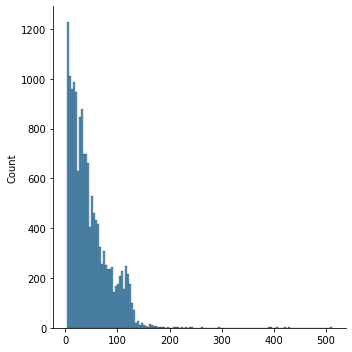

In [ ]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt,max_length=512, truncation=True)
  token_lens.append(len(tokens))


sns.displot(token_lens)
# plt.xlim([0,256])
# plt.xlabel('Token count')

## Datasets, Dataloaders, Optimizer, Losses and Model building

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Creating a dataset which inputs the reviews and targets in text form and outputs the tokenized reviews with attention mask

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self,item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        max_length = self.max_len, 
        add_special_tokens = True ,
        return_token_type_ids = False,
        pad_to_max_length = True ,
        # padding = 'max_length',
        return_attention_mask = True, 
        return_tensors='pt'
    )

    return {'review_text' : review,
             'input_ids': encoding['input_ids'].flatten(),
             'attention_mask': encoding['attention_mask'].flatten(),
             'targets': torch.tensor(target,dtype = torch.long)}
    

In [ ]:
# splitting the train, validation and test set
df_train, df_test = train_test_split(df, test_size = .1)
df_val, df_test = train_test_split(df_test, test_size = .5)

df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
# dataloaders to create batches of the dataset
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds, batch_size = batch_size, num_workers = 4
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# checking the size of one batch output from data loader
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
# initializing the bert model 
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# last_hidden_state, pooled_output = bert_model(
#     input_ids = encoding['input_ids'],
#     attention_mask = encoding['attention_mask']
# )

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# custom classifier with added dropout and linear layer for predictions 
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p = 0.3 )
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask, 
        return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# getting the gpu information 
device = torch.device ("cuda:0" if torch.cuda.is_available() else 'cpu')

In [ ]:
# sending the model and data to gpu to execute
model = SentimentClassifier(len(num_classes))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias= False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# training epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0


  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)


    outputs = model(input_ids = input_ids, attention_mask = attention_mask)

    _,preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm= 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/ n_examples, np.mean(losses)




In [ ]:
# validation epoch with no gradient 
def eval_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)


      outputs = model(input_ids = input_ids, attention_mask = attention_mask)

      _,preds = torch.max(outputs, dim = 1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())


    return correct_predictions.double()/ n_examples, np.mean(losses)



In [ ]:
# Final run 
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch { epoch+1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_data_loader, 
                                      loss_fn, 
                                      optimizer,
                                      device, 
                                      scheduler, 
                                      len(df_train)
                                      )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,
                                      val_data_loader, 
                                      loss_fn, 
                                      optimizer,
                                      device, 
                                      scheduler, 
                                      len(df_val)
                                      )
  
  print(f'  you
  Val loss {val_loss} accuracy {val_acc}')


  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  

Epoch 1/5
----------
Train loss 0.7795061444859472 accuracy 0.6394749841225037
Val loss 0.6299355527758599 accuracy 0.7229987293519695
Epoch 2/5
----------
Train loss 0.49462496900918385 accuracy 0.8106696775104086
Val loss 0.5252863004803657 accuracy 0.8157560355781449
Epoch 3/5
----------
Train loss 0.2846927209147599 accuracy 0.9056523886811093
Val loss 0.5286059140786529 accuracy 0.8640406607369759
Epoch 4/5
----------
Train loss 0.18552562279225185 accuracy 0.9468633123985605
Val loss 0.6018107074312866 accuracy 0.8831003811944091
Epoch 5/5
----------
Train loss 0.13513916204778087 accuracy 0.9631642085950181
Val loss 0.6621459607873112 accuracy 0.8831003811944091
CPU times: user 35min 29s, sys: 2min 41s, total: 38min 11s
Wall time: 38min 22s


In [ ]:
plt.plot(history['train_acc'], label = 'train accuracy')
plt.plot(history['val_acc'], label = 'val accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])